Initial testing of model development

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import datetime
import matplotlib.pyplot as plt

In [3]:
contingencies = xr.load_dataset('data/raw_data/contingency_regions.nc')

In [4]:
contingencies

<xarray.Dataset> Size: 13MB
Dimensions:  (time: 16436, hazard: 4, region: 6)
Coordinates:
  * time     (time) <U12 789kB '197901010000' '197901020000' ... '202312310000'
  * hazard   (hazard) <U10 160B 'Wind' 'Hail' 'Tornado' 'All Hazard'
  * region   (region) <U12 288B 'West' 'Great Plains' ... 'Northeast' 'CONUS'
Data variables:
    a        (time, hazard, region) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    b        (time, hazard, region) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    c        (time, hazard, region) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    d        (time, hazard, region) float64 3MB 477.0 264.0 ... 93.0 1.325e+03
Attributes:
    description:  Number of a, b, c, and d in contingency tables for each day...

In [5]:
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)

In [6]:
ds

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 11MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 5TB ...
Attributes:
    valid_time_start:       1940-01-01
    last_updated:           2025-07-23 01:54:31.932125+00:00
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-07-17

Building Basic ML model that predicts [bias and directional shifts for each var] from some ERA5 variables

In [7]:
contingencies_all = contingencies.sel(hazard = 'All Hazard', region = 'CONUS')
contingencies_wind = contingencies.sel(hazard = 'Wind', region = 'CONUS')
contingencies_hail = contingencies.sel(hazard = 'Hail', region = 'CONUS')
contingencies_tor = contingencies.sel(hazard = 'Tornado', region = 'CONUS')

In [8]:
# select subset of weather variables from ds
ds_subset = ds.sel(latitude = slice(40, 38), longitude = slice(360-85, 360-84))
# ds_subset = ds_subset[['2m_dewpoint_temperature', '2m_temperature', 'convective_available_potential_energy', 'convective_inhibition', 'potential_vorticity', 'specific_humidity', 'geopotential', 'u_component_of_wind', 'v_component_of_wind', '10m_u_component_of_wind', '10m_v_component_of_wind']]
ds_subset = ds_subset[['2m_dewpoint_temperature', '2m_temperature', 'convective_available_potential_energy', 'convective_inhibition', '10m_u_component_of_wind', '10m_v_component_of_wind']]
ds_subset

<xarray.Dataset> Size: 1GB
Dimensions:                                (time: 1323648, latitude: 9,
                                            longitude: 5)
Coordinates:
  * latitude                               (latitude) float32 36B 40.0 ... 38.0
  * longitude                              (longitude) float32 20B 275.0 ... ...
  * time                                   (time) datetime64[ns] 11MB 1900-01...
Data variables:
    2m_dewpoint_temperature                (time, latitude, longitude) float32 238MB ...
    2m_temperature                         (time, latitude, longitude) float32 238MB ...
    convective_available_potential_energy  (time, latitude, longitude) float32 238MB ...
    convective_inhibition                  (time, latitude, longitude) float32 238MB ...
    10m_u_component_of_wind                (time, latitude, longitude) float32 238MB ...
    10m_v_component_of_wind                (time, latitude, longitude) float32 238MB ...
Attributes:
    valid_time_start:       1940-01-01
    last_updated:           2025-07-23 01:54:31.932125+00:00
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-07-17

In [9]:
ds_subset.nbytes/(10**9)

1.44012908

In [10]:
pods = contingencies_all['a'] / (contingencies_all['a'] + contingencies_all['c'])
fars = contingencies_all['b'] / (contingencies_all['a'] + contingencies_all['b'])
all_bias = (contingencies_all['a'] + contingencies_all['b']) / (contingencies_all['a'] + contingencies_all['c'])
wind_bias = (contingencies_wind['a'] + contingencies_wind['b']) / (contingencies_wind['a'] + contingencies_wind['c'])
hail_bias = (contingencies_hail['a'] + contingencies_hail['b']) / (contingencies_hail['a'] + contingencies_hail['c'])
tor_bias = (contingencies_tor['a'] + contingencies_tor['b']) / (contingencies_tor['a'] + contingencies_tor['c'])

In [ ]:
pph = xr.load_dataset('/data/raw_data/labelled_pph.nc')

In [ ]:
pph

In [ ]:
all_east_shift = pph['E_SH_NUM']
all_north_shift = pph['N_SH_NUM']
wind_east_shift = pph['E_SH_W_NUM']
wind_north_shift = pph['N_SH_W_NUM']
hail_east_shift = pph['E_SH_H_NUM']
hail_north_shift = pph['N_SH_H_NUM']
tor_east_shift = pph['E_SH_T_NUM']
tor_north_shift = pph['N_SH_T_NUM']

In [1]:
# select moderate days in both datasets, split into training and testing. For now, just choose days where a != 0 (so no nans)

missing_dates = ['200204250000', '200208300000', '200304150000', '200304160000', '200306250000', '200307270000', '200307280000', '200312280000', '200404140000', '200408090000', '200905280000', '201105210000', '202005240000', '200510240000']

dates_of_interest = pph['time'][pph['MAX_CAT'].isin(['MDT', 'HIGH'])]
dates_of_interest = dates_of_interest[dates_of_interest > '200203310000']
dates_of_interest = dates_of_interest[~(dates_of_interest.isin(missing_dates))]

# select dates in pods and fars
pods_of_interest = pods.sel(time = dates_of_interest)
fars_of_interest = fars.sel(time = dates_of_interest)

# select dates in target variables
all_bias = all_bias.sel(time = dates_of_interest)
wind_bias = wind_bias.sel(time = dates_of_interest)
hail_bias = hail_bias.sel(time = dates_of_interest)
tor_bias = tor_bias.sel(time = dates_of_interest)

all_east_shift = all_east_shift.sel(time = dates_of_interest)
all_north_shift = all_north_shift.sel(time = dates_of_interest)
wind_east_shift = wind_east_shift.sel(time = dates_of_interest)
wind_north_shift = wind_north_shift.sel(time = dates_of_interest)
hail_east_shift = hail_east_shift.sel(time = dates_of_interest)
hail_north_shift = hail_north_shift.sel(time = dates_of_interest)
tor_east_shift = tor_east_shift.sel(time = dates_of_interest)
tor_north_shift = tor_north_shift.sel(time = dates_of_interest)

# select dates in ds_subset
dates = pd.to_datetime(dates_of_interest.str.slice(0, 8).values, format='%Y%m%d')

# Get the dates of each time value, dropping hours/minutes/seconds
time_dates = ds_subset['time'].dt.floor('D')

# Subset to only the days in the date_list
ds_of_interest = ds_subset.sel(time=ds['time'].where(time_dates.isin(dates), drop=True))

NameError: name 'pph' is not defined

In [16]:
# can try with one frame per day--this will get us to fewer variables than examples, which may be necessary for at least linear regression
ds_of_interest = ds_of_interest.sel(time=datetime.time(0))

In [17]:
ds_of_interest = ds_of_interest.compute()

In [18]:
ds_of_interest.to_zarr('data/processed_data/test_era5.zarr', mode = 'a')

In [25]:
# ds_of_interest = xr.open_zarr('data/processed_data/test_era5.zarr')

In [26]:
# ds_of_interest = ds_of_interest.compute()

In [28]:
cin_flag = xr.where(ds_of_interest.convective_inhibition.isnull(), 1, 0)
cin_filled = ds_of_interest.convective_inhibition.fillna(0)
ds_of_interest['convective_inhibition'] = cin_filled
ds_of_interest['cin_flag'] = cin_flag

In [29]:
# normalize ds_of_interest by variable
for var_name, var_data in ds_of_interest.data_vars.items():
    mean_val = var_data.mean()
    std_val = var_data.std()
    ds_of_interest[var_name] = (var_data - mean_val) / std_val

In [ ]:
# Step 1: Collect bias DataArrays into a list
bias_das = [
    ('All Hazard', all_bias),
    ('Wind', wind_bias),
    ('Hail', hail_bias),
    ('Tornado', tor_bias)
]

# Step 2: Convert bias DataArrays to one DataFrame
bias_rows = []
for hazard_name, da in bias_das:
    df = da.to_dataframe(name='bias').reset_index()
    df['hazard'] = hazard_name
    bias_rows.append(df)

bias_df = pd.concat(bias_rows, ignore_index=True)

# Step 3: Get east_shift and north_shift into one DataFrame
east_df = xr.concat(
    [all_east_shift, wind_east_shift, hail_east_shift, tor_east_shift],
    dim='hazard'
).assign_coords(hazard=['All Hazard', 'Wind', 'Hail', 'Tornado']).to_dataframe(name='east_shift').reset_index()

north_df = xr.concat(
    [all_north_shift, wind_north_shift, hail_north_shift, tor_north_shift],
    dim='hazard'
).assign_coords(hazard=['All Hazard', 'Wind', 'Hail', 'Tornado']).to_dataframe(name='north_shift').reset_index()

# Step 4: Merge all together on time and hazard
target_df = bias_df.merge(east_df, on=['time', 'hazard']).merge(north_df, on=['time', 'hazard'])

# Optional: reorder columns
target_df = target_df[['time', 'hazard', 'bias', 'east_shift', 'north_shift']]

In [35]:
# TODO normalize target variables (after putting into one df)
# some biases are inf or 0?
all_bias

<xarray.DataArray (time: 360)> Size: 3kB
array([0.56157563, 1.08750056, 1.12143031, 0.72993241, 6.79625   ,
       1.50655974, 3.93856499, 1.06801823, 0.3777201 , 0.61713627,
       0.63521575, 0.82029887, 0.62866038, 1.17213248, 1.76445415,
       1.33353918, 0.5029954 , 0.72759925, 0.80035747, 0.74659817,
       0.56279767, 2.45348987, 0.37126775, 0.55748877, 0.67295292,
       1.05560493, 1.71124996, 0.49350142, 0.97664726, 0.48536008,
       1.53166137, 0.65441943, 1.03996988, 1.62455255, 1.46825362,
       1.06405099, 0.82066468, 1.35526962, 1.66896552, 0.95324418,
       0.68558811, 0.715367  , 1.19492826, 0.66173757, 0.94604805,
       0.57035445, 0.75685303, 0.68618296, 0.55566606, 1.88335655,
       0.59224613, 0.78247688, 0.73156699, 1.25226538, 0.81111382,
       1.20525994, 1.38365833, 1.12828917, 0.69713432, 0.97300207,
       0.93601256, 0.52284221, 0.62750532, 0.82120056, 0.90758447,
       0.81421916, 0.24914809, 1.26826432, 0.5525761 , 0.62556179,
       0.88796035, 0.79391718, 1.44530497, 1.64477901, 0.74916029,
       0.79508546, 0.42793279, 1.225     , 0.82580835, 0.39614302,
       2.27375248, 0.77319886, 0.75112406, 0.48576872, 0.58787685,
       0.78824291, 0.31713848, 1.0602869 , 0.7540882 , 0.37997707,
       0.65699675, 1.08276857, 0.84341662, 1.37892094, 0.5089216 ,
       0.6769654 , 0.20421408, 0.46789212, 0.97271049, 0.78519647,
...
       0.81877181, 0.38966174, 0.55642856, 0.96023763, 1.06445482,
       0.58450985, 1.68701892, 0.72536843, 0.61836789, 0.39105503,
       1.54860276, 0.53392483, 0.59692954, 0.71585876, 3.6276293 ,
       0.40944348, 0.65543686, 0.74057086, 1.78320155, 0.5090442 ,
       0.48423263, 0.50110988, 0.4704334 , 0.86375215, 0.44078019,
       0.61102192, 0.39777204, 0.77609629, 0.56340811, 0.50883334,
       0.61811824, 0.39565869, 0.54414985, 0.4483138 , 1.12115274,
       1.14270008, 0.53252676, 0.38020471, 0.61120935, 0.87176395,
       0.5204172 , 0.5871502 , 0.79815869, 0.50467982, 0.559992  ,
       0.73190384, 0.65431209, 0.56371491, 0.74427356, 0.43371648,
       0.54057758, 0.29394359, 0.30770778, 0.43311977, 0.75549273,
       0.74852076, 0.94101665, 0.45351039, 0.36811287, 0.57280222,
       0.34294723, 0.2802516 , 0.45211984, 0.46858189, 0.34517955,
       0.19520996, 0.47918282, 0.97257026, 0.39904776, 0.33637791,
       0.5323751 , 0.72714461, 0.37929675, 0.30770771, 0.46051277,
       0.6153942 , 0.41734806, 0.426433  , 0.32282832, 0.75939102,
       0.91829976, 0.84228616, 0.33197078, 0.56853061, 0.39273164,
       0.30476014, 0.40618458, 0.17937587, 0.54242071, 0.52883366,
       0.56255667, 0.42250005, 0.37133643, 0.25715406, 0.59177451,
       0.64365692, 0.3166416 , 0.49513519, 0.34282539, 0.27517712])
Coordinates:
  * time     (time) <U12 17kB '200204070000' '200204130000' ... '202306150000'
    hazard   <U10 40B 'All Hazard'
    region   <U12 48B 'CONUS'

In [ ]:
# Convert ds_of_interest time to 'YYYYMMDD0000' format for matching
input_dates = ds_of_interest['time'].dt.strftime('%Y%m%d0000').values

In [ ]:
# TODO add DOY variable

In [20]:
# Filter only matching dates
matching_dates = np.intersect1d(input_dates, fars_of_interest['time'].values)

dates = pd.to_datetime(matching_dates, format='%Y%m%d0000')

train_mask = dates < pd.Timestamp('2020-01-01')
test_mask = dates >= pd.Timestamp('2020-01-01')

In [21]:
class LazyWeatherDataset(Dataset):
    def __init__(self, ds, dates, fars, pods):
        self.ds = ds
        self.dates = dates
        self.fars = fars
        self.pods = pods

    def __len__(self):
        return len(self.dates)

    def __getitem__(self, idx):
        # Select the date and corresponding FAR/POD
        date = self.dates[idx]
        daily_ds = self.ds.sel(time=self.ds['time'].dt.strftime('%Y%m%d0000') == date)

        # Flatten daily inputs without loading the full dataset into memory
        daily_inputs = daily_ds.to_array().stack(flat=('latitude', 'longitude', 'time')).values.flatten()  # include 'level', if needed
        target = np.array([self.fars.sel(time=date).values, self.pods.sel(time=date).values])

        return torch.tensor(daily_inputs, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


# Create datasets
train_dataset = LazyWeatherDataset(ds_of_interest, matching_dates[train_mask], fars_of_interest, pods_of_interest)
test_dataset = LazyWeatherDataset(ds_of_interest, matching_dates[test_mask], fars_of_interest, pods_of_interest)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=train_dataset.__len__(), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.__len__(), shuffle=False)

In [42]:
# define model (one layer nn with pytorch)
# Get input size by flattening one day's inputs
sample_date = matching_dates[0]
sample_ds = ds_of_interest.sel(time=ds_of_interest['time'].dt.strftime('%Y%m%d0000') == sample_date)
input_size = sample_ds.to_array().stack(flat=('latitude', 'longitude', 'time')).size  # include 'level', if needed

# Define the model
model = nn.Linear(input_size, 2)

In [48]:
# train model

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.SGD(model.parameters(), lr=0.01)

train_losses = []
test_losses = []

num_its = 100

for epoch in range(num_its):
    model.train()
    running_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_test_loss += loss.item()
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch + 1}/{num_its}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

Epoch [1/100], Train Loss: 0.5886, Test Loss: 1.2235
Epoch [2/100], Train Loss: 1.7005, Test Loss: 0.3260
Epoch [3/100], Train Loss: 0.4698, Test Loss: 0.0881
Epoch [4/100], Train Loss: 0.1496, Test Loss: 0.4952
Epoch [5/100], Train Loss: 0.7805, Test Loss: 0.4276
Epoch [6/100], Train Loss: 0.6634, Test Loss: 0.1066
Epoch [7/100], Train Loss: 0.1549, Test Loss: 0.0669
Epoch [8/100], Train Loss: 0.0815, Test Loss: 0.2830
Epoch [9/100], Train Loss: 0.3759, Test Loss: 0.3623
Epoch [10/100], Train Loss: 0.4417, Test Loss: 0.2188
Epoch [11/100], Train Loss: 0.1994, Test Loss: 0.0794
Epoch [12/100], Train Loss: 0.0300, Test Loss: 0.0896
Epoch [13/100], Train Loss: 0.1293, Test Loss: 0.1522
Epoch [14/100], Train Loss: 0.2788, Test Loss: 0.1294
Epoch [15/100], Train Loss: 0.2357, Test Loss: 0.0489
Epoch [16/100], Train Loss: 0.0738, Test Loss: 0.0235
Epoch [17/100], Train Loss: 0.0115, Test Loss: 0.0767
Epoch [18/100], Train Loss: 0.0977, Test Loss: 0.1196
Epoch [19/100], Train Loss: 0.1750, T

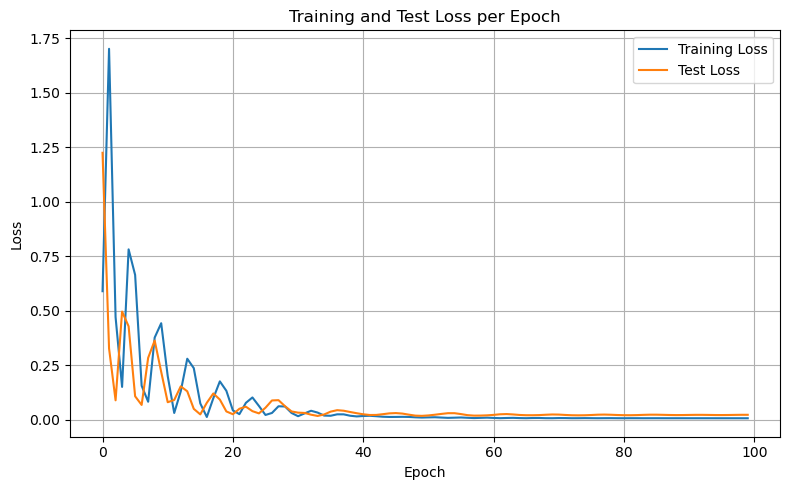

In [49]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# test model
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 0.1044
